Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!

In [24]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, RocCurveDisplay
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/Spaceship Titanic/train.csv")
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [4]:
df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [5]:
# Fix the missing data, convert to numerical, clean the data

df["VIP"] = df["VIP"].astype(str)
df["CryoSleep"] = df["CryoSleep"].astype(str)
df["Transported"] = df["Transported"].astype(int)


cat_imputer = make_pipeline((SimpleImputer(strategy="constant", fill_value="missing")), 
                            (OneHotEncoder(handle_unknown="ignore")))
num_imputer = make_pipeline((SimpleImputer(strategy="mean")))

preprocessor = make_column_transformer((cat_imputer, ["PassengerId", "HomePlanet", "Cabin", 
                                                                      "Destination", "Name", 
                                                                      "CryoSleep", "VIP"]),
                                      (num_imputer, ["Age", "RoomService",
                                                    "FoodCourt", "ShoppingMall",
                                                    "Spa", "VRDeck"]))

X = df.drop("Transported", axis=1)
y = df["Transported"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
len(df)

8693

In [7]:
clf = make_pipeline((preprocessor), (RandomForestClassifier(n_jobs=-1)))
clf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['PassengerId', 'HomePlanet',
                                                   'Cabin', 'Destination',
                                                   'Name', 'CryoSleep',
                                                   'VIP']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck'])])),
                ('randomforestclassifier', RandomForestClassifier(n_jobs=-1))])

In [8]:
clf.score(X_train, y_train)

1.0

In [9]:
clf.score(X_test, y_test)

0.7809085681426107

In [74]:
random_forest_params = {
    'randomforestclassifier__n_estimators': [50, 100, 200],  # Number of trees in the forest
    'randomforestclassifier__criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'randomforestclassifier__max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'randomforestclassifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'randomforestclassifier__max_features': [16, 9],  # Number of features to consider for the best split
    'randomforestclassifier__bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    'randomforestclassifier__class_weight': [None, 'balanced', 'balanced_subsample']  # Class weights
}

In [75]:
rs_clf = RandomizedSearchCV(clf, random_forest_params, cv=5, n_jobs=-1, n_iter=25).fit(X_train, y_train)

In [76]:
rs_clf.best_params_

{'randomforestclassifier__n_estimators': 200,
 'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__max_features': 9,
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__bootstrap': False}

In [77]:
rs_clf.score(X_test, y_test)

0.7699827487061529

In [10]:
y_preds = clf.predict(X_test)

In [11]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78       849
           1       0.81      0.75      0.78       890

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



In [12]:
cm = confusion_matrix(y_test, y_preds)
cm

array([[694, 155],
       [226, 664]], dtype=int64)

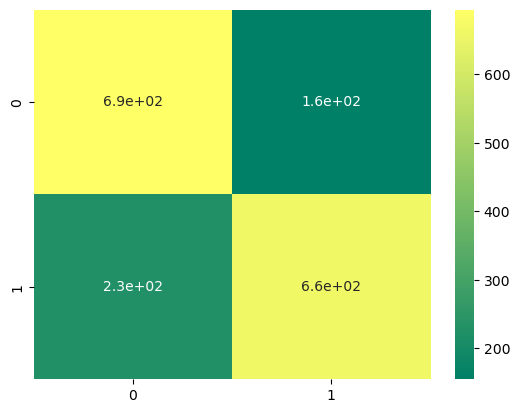

In [18]:
sn.heatmap(cm, annot=True, cmap="summer");

In [20]:
# Redo the test with the train data supplies

test_df = pd.read_csv("../data/Spaceship Titanic/test.csv")
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [23]:
test_preds = clf.predict(test_df)
test_df["Transported"] = pd.Series(test_preds)
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,0
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,1
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,1
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,0


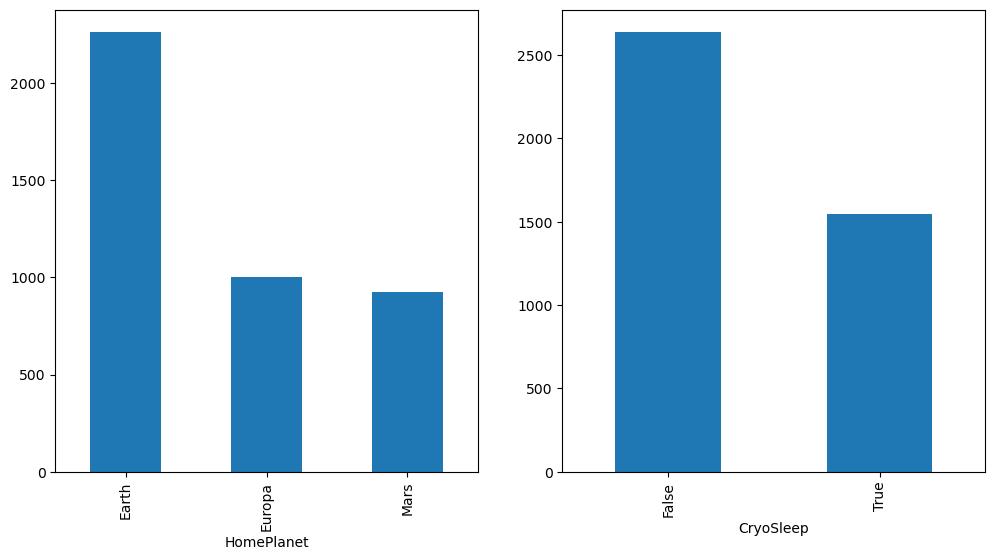

In [32]:
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
test_df["HomePlanet"].value_counts().plot(kind="bar", ax=ax1)
test_df["CryoSleep"].value_counts().plot(kind="bar", ax=ax2);